# Preparing `ssd_mobilenetv2` for Hailo-8

This notebook downloads a ssd_mobilnetv2 model from tensorflow object detection repo and passes it to the model translation tool chain: parsing, quantization, compilation. At each step, the intermediate HAR files are saved as [model_name]_orig.har, [model_name]_float.har, [model_name]_quantized.har.

In the compilation step, the [model_name].har and [model_name].hef files are saved.

At the end, 'hailo benchmark' is called to measure performance of the model on the Hailo-8 hardware. You need to have the hardware connected in order to run that step.

For calibration, a set of 32-64 images must be provided. Please set the below variable IMAGE_DIR accordingly.

Another notebook ssd_mobilenetv2_300x300_infer.ipynb, takes the HAR and HEF files produced by this notebook and can run the original CKPT model and the Hailo translated models on the host PC or the hardware to produce jpeg images with bounding boxes & scores around the detected objects. It can be used to visually validate the quality of the translated model for Hailo.

In [1]:
from pathlib import Path
import os

#MODEL      = 'ssd_mobilenet_v2_coco_2018_03_29' # 16.67 M parameters
#NMS_CONFIG_FILE= 'mobilenet_v2_nms_postprocess_config.json'

# The lite version uses depthwise convolution for Box encoding and in overall is 4.46 M parameters 
MODEL      = 'ssdlite_mobilenet_v2_coco_2018_05_09'
NMS_CONFIG_FILE= 'mobilenet_v2_ssdlite_nms_postprocess_config.json'

INPUT_WIDTH= 300
INPUT_HEIGHT= 300

# Set IMAGE_DIR to point to your input *.jpg images which will be used for calibration
HOME_DIR = str(Path.home())
IMAGE_DIR = HOME_DIR + '/workspace/datasets/coco/val2017'
# Set max number of images used for calibration
MAX_NUM_IMAGES= 64

BATCH_SIZE= 8

FPS= 452

WORKDIR= str(Path.cwd())
print (WORKDIR)
TMPMODEL= WORKDIR+"/tmpmodel"
!mkdir -p {TMPMODEL}

/home/victorc/workspace/mymodels/ssd_mobilenetv2


In [2]:
# Find Virtual environment path
import subprocess as sp
python3Path = sp.getoutput('which python3')
endPos= python3Path.find("/bin/python3")
if (endPos== -1):
    print ("Error could not find virtualenv path")
else:
    VENV_PATH= python3Path[0:endPos]
print("Virtual environment located at " + VENV_PATH)
        

Virtual environment located at /home/victorc/workspace/dataflow_compiler/hailo_virtual_env


In [3]:
import tensorflow as tf
import numpy as np
from hailo_sdk_client import ClientRunner, __version__, NNFramework
from hailo_sdk_common.preprocessing import Normalization

2022-05-19 16:00:26.929928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 16:00:26.929942: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/victorc/workspace/dataflow_compiler/hailo_virtual_env/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or t

In [4]:
print('TF version:', tf.__version__)
print('Hailo DFC version', __version__)

TF version: 2.5.2
Hailo DFC version 3.17.0


### __Downloading the model from a google repo__

In [5]:
%cd {TMPMODEL}
!wget -N --referer='http://css-tricks.com/forums/topic/font-face-in-base64-is-cross-browser-compatible/' http://download.tensorflow.org/models/object_detection/{MODEL}.tar.gz
!tar -zxf {MODEL}.tar.gz -C {TMPMODEL}

/home/victorc/workspace/mymodels/ssd_mobilenetv2/tmpmodel
--2022-05-19 16:00:29--  http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2607:f8b0:4008:809::2010, 142.250.189.144
Connecting to download.tensorflow.org (download.tensorflow.org)|2607:f8b0:4008:809::2010|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz’ not modified on server. Omitting download.



### __Parse the model to Hailo HAR file__

In [6]:
SAVED_MODEL_PATH= TMPMODEL + "/" + MODEL + "/saved_model"
CKPT_MODEL_PATH= TMPMODEL + "/" + MODEL + '/model.ckpt'
print (CKPT_MODEL_PATH)

/home/victorc/workspace/mymodels/ssd_mobilenetv2/tmpmodel/ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt


In [7]:
#start_node = 'input_tensor'
start_node = 'FeatureExtractor/MobilenetV2/MobilenetV2/Conv2d_0/Conv2D'
start_node = 'FeatureExtractor/MobilenetV2/Conv/Conv2D'

#start_node = 'input_tensor'
end_nodes  = [
    'BoxPredictor_0/BoxEncodingPredictor/BiasAdd',
    'BoxPredictor_0/ClassPredictor/BiasAdd',
    'BoxPredictor_1/BoxEncodingPredictor/BiasAdd',
    'BoxPredictor_1/ClassPredictor/BiasAdd',
    'BoxPredictor_2/BoxEncodingPredictor/BiasAdd',
    'BoxPredictor_2/ClassPredictor/BiasAdd',
    'BoxPredictor_3/BoxEncodingPredictor/BiasAdd',
    'BoxPredictor_3/ClassPredictor/BiasAdd',
    'BoxPredictor_4/BoxEncodingPredictor/BiasAdd',
    'BoxPredictor_4/ClassPredictor/BiasAdd',
    'BoxPredictor_5/BoxEncodingPredictor/BiasAdd',
    'BoxPredictor_5/ClassPredictor/BiasAdd'
]

mean_list = [127.5, 127.5, 127.5]
std_list = [127.5, 127.5, 127.5]
norm_obj = Normalization(mean_list, std_list)

tensor_shape = {'Preprocessor/sub:0' : [1,300,300,3]}

runner = ClientRunner()
_ = runner.translate_tf_model(CKPT_MODEL_PATH,
    MODEL,
    start_node_name=start_node,
    end_node_names=end_nodes,
    #tensor_shapes=tensor_shape, # comment out this line for ssdlite
    integrated_preprocess=norm_obj)#, nn_framework=NNFramework.TENSORFLOW2)

[warning] DEPRECATION WARNING: `integrated_preprocess` will be deprecated in future versions. Use Model Script commands instead.
                Example: normalization_layer1 = normalization([30.1], [0.3], input_layer1).
                For more details see Model Optimization Tutorial, `Model modifications using model script commands`


2022-05-19 16:00:29.760499: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 16:00:29.760530: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-19 16:00:29.796836: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 16:00:29.798131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-19 16:00:29.798142: W tensorflow/s

INFO:tensorflow:Restoring parameters from /tmp/tmpx9zgy_zj/ssdlite_mobilenet_v2_coco_2018_05_09.ckpt


2022-05-19 16:00:31.125855: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1689600000 Hz


[info] Restored TF model ssdlite_mobilenet_v2_coco_2018_05_09.
[info] Translation started on TF model ssdlite_mobilenet_v2_coco_2018_05_09
[info] Hailo Fuser is running
[info] Starting Fuser
[info] Translation completed on TensorFlow 1.x model ssdlite_mobilenet_v2_coco_2018_05_09
[info] Initialized runner for ssdlite_mobilenet_v2_coco_2018_05_09
[info] Nullified 908 of the channels in the model


In [8]:
MODEL_ORIG_HAR= MODEL + '_orig.har'
runner.save_har(MODEL_ORIG_HAR)

### __Add on-chip post-processing layer by calling add_nms_postprocess()__

Note that a json config file that describes some parameters must be passed to it.
Please refer to documentation NMS_API.pdf to understand how to write this JSON file.
For the ssdlite_mobilenet_v2_coco_2018_05_09, we just used the file mobilenet_v2_ssd_nms_postprocess_config.json from the hailo model zoo located in {HMZ_DATA}/models_files/ObjectDetection/Detection-COCO/ssd/ssd_mobilenet_v2/pretrained where HMZ_DATA is an the environment variable introduced in https://github.com/hailo-ai/hailo_model_zoo/blob/master/docs/DATA.md .
Note that for the purpose of this notebook, we renamed mobilenet_v2_ssd_nms_postprocess_config.json to mobilenet_v2_ssdlite_nms_postprocess_config.json since this notebook supports both the non-lite and lite version of ssd mobilenetv2.

In [9]:
from hailo_sdk_client.tools.core_postprocess.core_postprocess_api import add_nms_postprocess
from hailo_sdk_common.targets.inference_targets import ParamsKinds
add_nms_postprocess(runner, config_json_path=WORKDIR + '/' + NMS_CONFIG_FILE, params_kind=ParamsKinds.NATIVE)

[warning] DEPRECATION WARNING: `add_nms_postprocess` will be deprecated in future versions. Use Model Script commands instead.
        Example: nms_postprocess("nms_config.json", ssd).
        For more details see Model Optimization Tutorial, `Model modifications using model script commands`
[info] Initialized runner for ssdlite_mobilenet_v2_coco_2018_05_09
[info] Nullified 908 of the channels in the model


In [10]:
MODEL_FLOAT_HAR= MODEL + '_float.har'
runner.save_har(MODEL_FLOAT_HAR)

In [11]:
!hailo visualizer {MODEL_FLOAT_HAR}

2022-05-19 16:00:37.594800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 16:00:37.594820: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/victorc/workspace/dataflow_compiler/hailo_virtual_env/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or t

Run the profiler to check if any resource allocation issue arises.

In [12]:
!hailo profiler --mode pre_placement {MODEL_FLOAT_HAR}

2022-05-19 16:00:40.425621: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 16:00:40.425649: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/victorc/workspace/dataflow_compiler/hailo_virtual_env/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or t

[info] 
Model Details
---------------------------  ----------
Input Tensors Shapes         300x300x3
Operations per Input Tensor  1.50 GOPs
Operations per Input Tensor  0.76 GMACs
Model Parameters             4.46 M
---------------------------  ----------

Profiler Input Settings
-----------------  ----------------
Optimization Goal  Reach 172.20 FPS
Profiler Mode      Pre Placement
-----------------  ----------------

Performance Summary
-------------------------------  -----------
Number of Devices                1
Throughput (Bottleneck Layer)    172.20 FPS
Latency                          12.04 ms
Total NN Core Power Consumption  0.57 W
Operations per Second            0.01 GOP/s
Operations per Second            0.00 GMAC/s
-------------------------------  -----------


### Quantizing the model

For simplicity, in this case we're going to have a false quantization. This will NOT produce real results, until quantizing with real data

In [13]:
import PIL
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

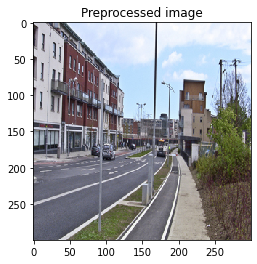

In [14]:
def convert_rgb_to_yuv(image):
    transition_matrix = np.array([[0.2568619, -0.14823364, 0.43923104],
                                  [0.5042455, -0.2909974, -0.367758],
                                  [0.09799913, 0.43923104, -0.07147305]])
    image = np.matmul(image, transition_matrix)
    image += [16, 128, 128]
    return image

def preproc_resize(path):  
    pil_image = Image.open(path)
    ip = pil_image.resize([INPUT_WIDTH, INPUT_HEIGHT])
    ip = np.array(ip)
    return ip

files = os.listdir(IMAGE_DIR)
files.sort()
files = files[0:MAX_NUM_IMAGES]
idx= 0
calib_dataset = np.zeros((len(files), INPUT_HEIGHT, INPUT_WIDTH, 3), dtype=np.float32)
for filename in files:
    if(os.path.isfile(os.path.join(IMAGE_DIR, filename)) and ('.jpg' in filename)):
        img_preproc= preproc_resize(os.path.join(IMAGE_DIR,filename))
        calib_dataset[idx,:,:,:] = img_preproc.astype(np.uint8)
        idx=idx+1
        
plt.imshow(np.array(calib_dataset[idx-1,:,:,:], np.uint8), interpolation='nearest')
plt.title('Preprocessed image')
plt.show()

Create a quantization/compilation script in which last line sets the resizer operating mode to streaming. This is to avoid errors such as "Hailo tools builder failed: Model uses too many reources: 119 L4 memory cuts"

In [15]:
CALIB_SET_SIZE= len(files)
with open('model.alls', 'w') as FH:
    FH.write(f'model_optimization_config(calibration, batch_size={BATCH_SIZE})\n')
    FH.write(f'model_optimization_config(calibration, calibset_size={CALIB_SET_SIZE})\n')
    FH.write('post_quantization_optimization(bias_correction, policy=enabled)\n')
    FH.write('compilation_param({*}, resources_allocation_strategy=min_l3_mem_match_fps)\n')
    FH.write('compilation_param({conv*}, balance_output_multisplit=False)\n')
    FH.write('allocator_param(automatic_ddr= False )\n')

In [16]:
runner.quantize(calib_dataset)
MODEL_QUANTIZED_HAR= MODEL + '_quantized.har'
runner.save_har(MODEL_QUANTIZED_HAR)

[info] Starting Quantization
[info] Using a calibration set of 64 entries for quantization
[info] Creating graph from hn
[info] Loading model configuration from config_file
[info] Loading params from npz
[warning] GPU policy set to enabled, no GPU detected
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
[info] Starting Equalization
[info] Creating graph from hn
[info] Loading model configuration from config_file
[info] Loading params from npz


2022-05-19 16:01:47.914761: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


[info] Equalization configuration:
[info]     Default policy: enabled
[info]     Mode: min_based
[info] Starting Equalization of component 1 out of 1
[info] Skipped Equalization of layers {'ssdlite_mobilenet_v2_coco_2018_05_09/conv51_linear0', 'ssdlite_mobilenet_v2_coco_2018_05_09/conv39_linear0', 'ssdlite_mobilenet_v2_coco_2018_05_09/conv28_linear0', 'ssdlite_mobilenet_v2_coco_2018_05_09/conv43_linear0', 'ssdlite_mobilenet_v2_coco_2018_05_09/conv54_linear0', 'ssdlite_mobilenet_v2_coco_2018_05_09/conv47_linear0'} because of unsupported layers: {('ssdlite_mobilenet_v2_coco_2018_05_09/bbox_decoder54', 'bbox_decoder'), ('ssdlite_mobilenet_v2_coco_2018_05_09/bbox_decoder28', 'bbox_decoder'), ('ssdlite_mobilenet_v2_coco_2018_05_09/bbox_decoder51', 'bbox_decoder'), ('ssdlite_mobilenet_v2_coco_2018_05_09/bbox_decoder39', 'bbox_decoder'), ('ssdlite_mobilenet_v2_coco_2018_05_09/bbox_decoder43', 'bbox_decoder'), ('ssdlite_mobilenet_v2_coco_2018_05_09/bbox_decoder47', 'bbox_decoder')}.
[info] Ski

### Compiling the model

Pass the script as argument

In [17]:
hef = runner.get_hw_representation(allocator_script_filename='model.alls', fps= FPS)

[warning] Taking model script commands from model.alls and ignoring previous allocation script commands
[info] Loading network parameters
[info] Starting Hailo allocation, compilation and context switch abstraction flow
[info] Running Allocator: Strategy=POSITIVE-SEARCH, Validate=true, Cluster timeout=5m 0s, Network Required FPS=452
[info] Starting Network Adjustments, Setting Timeout to: 20m 0s
[info] Running with Single-context flow
[info] Resources optimization guidelines: Strategy -> GREEDY Objective -> REQUIRED_FPS
[info] Resources optimization params: max_control_utilization=120%, max_compute_utilization=100%, max_memory_utilization (weights)=100%
[info] Running Auto-Merger: max_auto_merge_depth=2, merge_min_layer_utilization=0.95, merge_max_layer_utilization=1.2, merge_max_memory_utilization=1.0
[info] Start adding L4 portals
[info] Adding a portal between proposal_generator0( index=5215, name=proposal_generator0, ) and proposal_generator0_concat, type: L4
[info] Network FPS fro

[info] Context:0/0 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1  *          V          *          V          V          *          *          V          V       
 worker2                                                                                                  
 worker3                                                                                                  

  00:08
[info] Context:0/0 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1  *          V          V          V          V          *          V          V          V       
 worker2     

[info] Context:0/0 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  V          V          V          V          V          V          V          V          V       
 worker1  V          V          V          V          V          V          V          V          V       
 worker2  *          *          *          *          *          *          *          *          V       
 worker3                                                                                                  

  00:18
[info] Context:0/0 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  V          V          V          V          V          V          V          V          V       
 worker1  V          V          V          V          V          V          V          V          V       
 worker2  *  

In [18]:
MODEL_HAR= MODEL + '.har'
runner.save_har(MODEL_HAR)

with open(MODEL + '.hef', 'wb') as FH:
    FH.write(hef)

### Verify performance on the target if connected

In [20]:
#Comment below line if no hardware is connected
!hailortcli benchmark {MODEL}.hef

Starting Measurements...
Measuring FPS in hw_only mode
Network ssdlite_mobilenet_v2_coco_2018_05_09/ssdlite_mobilenet_v2_coco_2018_05_09: 6% | 484 | FPS: 484.02 | ETA: 00:00:14
Network ssdlite_mobilenet_v2_coco_2018_05_09/ssdlite_mobilenet_v2_coco_2018_05_09: 13% | 971 | FPS: 485.46 | ETA: 00:00:13
Network ssdlite_mobilenet_v2_coco_2018_05_09/ssdlite_mobilenet_v2_coco_2018_05_09: 20% | 1458 | FPS: 485.96 | ETA: 00:00:12
Network ssdlite_mobilenet_v2_coco_2018_05_09/ssdlite_mobilenet_v2_coco_2018_05_09: 26% | 1945 | FPS: 486.21 | ETA: 00:00:11
Network ssdlite_mobilenet_v2_coco_2018_05_09/ssdlite_mobilenet_v2_coco_2018_05_09: 33% | 2431 | FPS: 486.15 | ETA: 00:00:10
Network ssdlite_mobilenet_v2_coco_2018_05_09/ssdlite_mobilenet_v2_coco_2018_05_09: 40% | 2918 | FPS: 486.29 | ETA: 00:00:09
Network ssdlite_mobilenet_v2_coco_2018_05_09/ssdlite_mobilenet_v2_coco_2018_05_09: 46% | 3405 | FPS: 486.38 | ETA: 00:00:08
Network ssdlite_mobilenet_v2_coco_2018_05_09/ssdlite_mobilenet_v2_coco_2018_05_0